In [2]:
# Loading the images via git clone to the VM in colab

!git clone https://github.com/Andrespp123/CNN_Challenge

Cloning into 'CNN_Challenge'...
remote: Enumerating objects: 2357, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2357 (delta 0), reused 4 (delta 0), pack-reused 2353
Receiving objects: 100% (2357/2357), 309.12 MiB | 13.43 MiB/s, done.


In [57]:
# Importing dependencies

import logging
import os
import warnings
import time

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import imgaug.augmenters as  iaa
import cv2

from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from glob import glob
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [4]:
# Reading the mapping CSV

df = pd.read_csv("/content/CNN_Challenge/train.csv")
df.head(5)

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


Columns "latitude", "longitude" and "year" will be dropped because a convolutional neural network has no use for any of that kind of information. 

In [5]:
# Dropping the columns using pandas methods
df = df.drop(['latitude', 'longitude', 'year' ], axis=1)

In [6]:
# Confirming how the Dataframe looks now
print("The dataframe has a total of", df.shape[0], "images for classification.")
df.head(5)

The dataframe has a total of 1714 images for classification.


,label,example_path
0,0,train_test_data/train/1297.png
1,2,train_test_data/train/1199.png
2,0,train_test_data/train/1348.png
3,0,train_test_data/train/2214.png
4,0,train_test_data/train/2220.png


The distribution of labels inside the dataset will be checked to evaluate if additional rebalancing is needed.

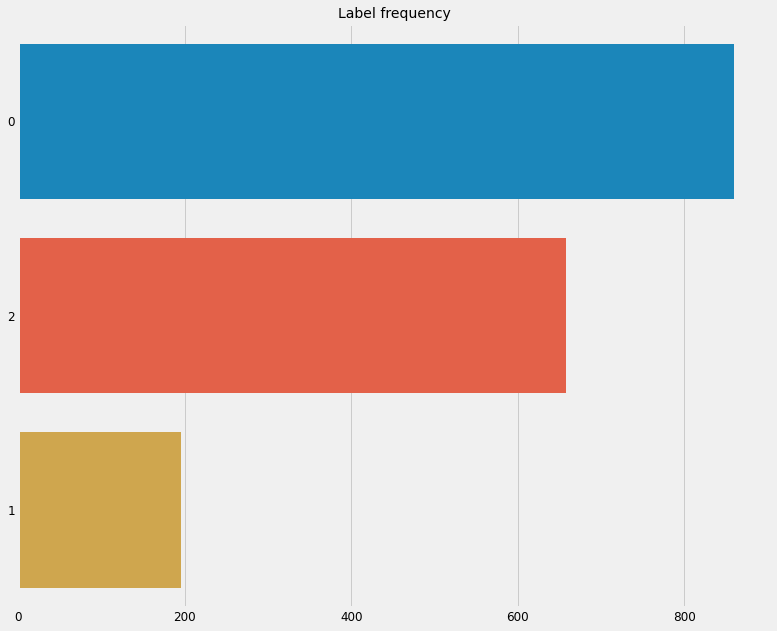

In [7]:
# Get label frequencies in descending order

label_freq = df['label'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot

style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

It is clearly visible that there is a remarked minority on label 1

In [8]:
# Looking at it from a percentage perspective
print(df['label'].value_counts(normalize=True) * 100)
print("Only 11% label 1 (Corresponding to Grassland)")

0    50.175029
2    38.389732
1    11.435239
Name: label, dtype: float64
Only 11% label 1 (Corresponding to Grassland)


There are several options to take when facing a problem like this, mainly:


*   Undersampling the dominant label group 
*   Oversampling the small label group
*   Setting higher weigths on that specific group 
*   Augmenting images




In [9]:
# Starting the Image augmentation process with imgaug

# Loading Dataset
images = []
images_path = glob("/content/CNN_Challenge/train_test_data/train/*.png")
for img_path in images_path:
  img = cv2.imread(img_path)
  images.append(img)

# Image augmentation
augmentation = iaa.Sequential([
    # 1. Flip
    # Horizontal flip
    iaa.Fliplr(0.5),
    # Vertical Flip
    iaa.Flipud(0.5),

    # 2. Affine
    iaa.Affine(translate_percent= {"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30,30),
               scale=(0.5, 1.5)),
    # 3. Multiply
    iaa.Multiply((0.8, 1.2)),

    # 4. Linear contrast
    iaa.LinearContrast((0.6, 1.4)),
])

We previously created the image_augmentation function, this is what it is randomly doing:



*   Flipping the horizontal image orientation.
*   Flipping the vertical image orientation.
*   Tilting the image in a random amount of degrees between (-30 and 30).
*   Varying the scale of the image.
*   Varying the amount of contrast between 80% and 120%
*   Varying the amount of contrast in the image.


In theory this would fix the problem of the low general sample count that we currently have. 

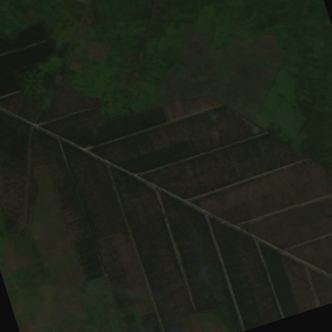

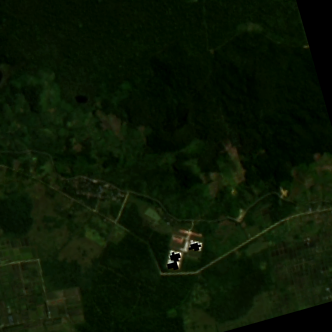

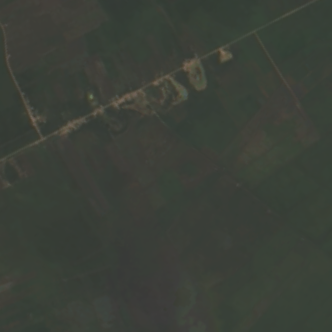

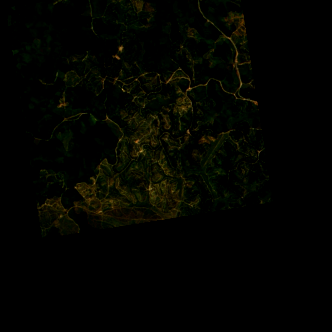

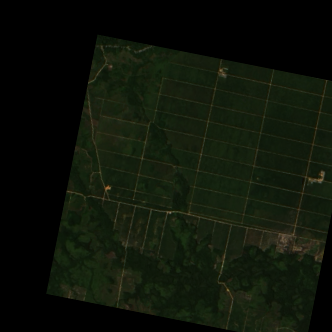

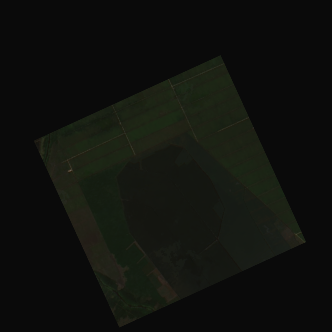

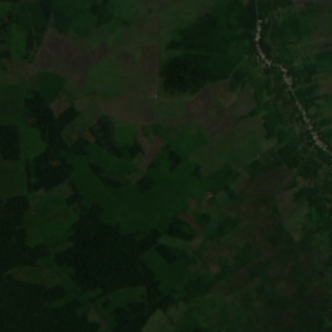

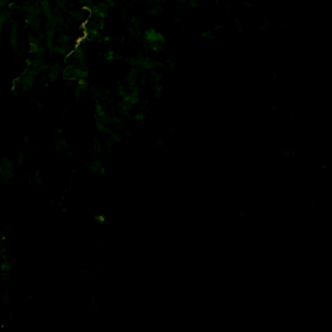

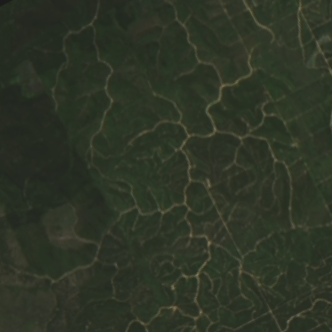

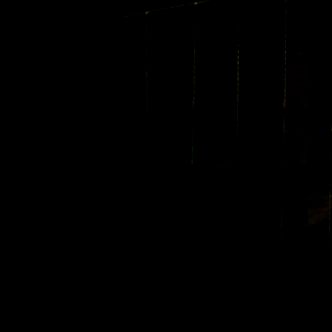

In [10]:
# To be looked at in further detail
augmented_images = augmentation(images=images)
for i in range(10):
  cv2_imshow(augmented_images[i])

## Train / Val split

In [11]:
# Randomly plitting the modeling data into training and validation 80%-20% is common in machine learning practice
# random_state=4 so the results are reproducible (otherwise the split randomly varies)

X_train, X_val, y_train, y_val = train_test_split(df['example_path'], df['label'], test_size=0.2, random_state=4)

# Confirming the split

print("Number of satellite images for training: ", len(X_train))
print("Number of satellite images for validation: ", len(X_val))

Number of satellite images for training:  1371
Number of satellite images for validation:  343


In [12]:
# Concatenating image_names with their absolute paths for later use

X_train = [os.path.join('/content/CNN_Challenge/', str(f)) for f in X_train]
X_val = [os.path.join('/content/CNN_Challenge/', str(f)) for f in X_val]
X_train[:3]

['/content/CNN_Challenge/train_test_data/train/62.png',
 '/content/CNN_Challenge/train_test_data/train/381.png',
 '/content/CNN_Challenge/train_test_data/train/416.png']

In [13]:
# Confirming how the individual labels look for the images on each split.

y_train = list(y_train)
y_val = list(y_val)
print("This is how the labels look for the training split", y_train[:3])
print("This is how the labels look for the validation split", y_val[:3])

This is how the labels look for the training split [0, 2, 0]
This is how the labels look for the validation split [0, 0, 0]


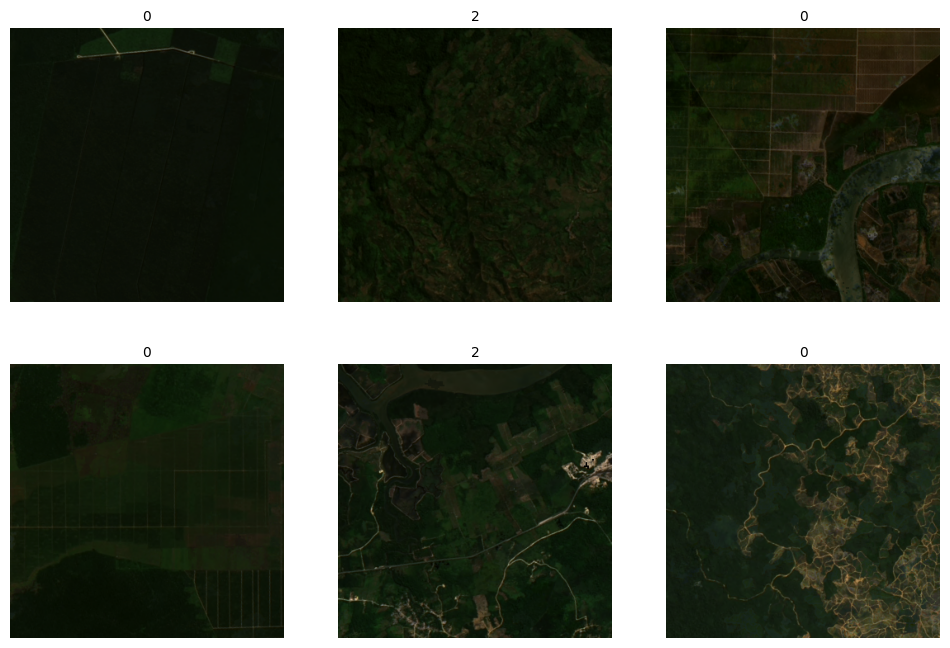

In [14]:
# Taken from tensorflow's website to get image samples.

nobs = 6 # Maximum number of images to display
ncols = 3 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

It is better for the model if the labels are in a one hot encoding format

In [15]:
# Transform the targets of the training and test sets

mlb = LabelBinarizer()
mlb.fit(y_train)
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)
N_LABELS = len(mlb.classes_)

In [16]:
# Print example of images with their labels and their binary targets

for i in range(3):
    print(X_train[i], y_train_bin[i])

/content/CNN_Challenge/train_test_data/train/62.png [1 0 0]
/content/CNN_Challenge/train_test_data/train/381.png [0 0 1]
/content/CNN_Challenge/train_test_data/train/416.png [1 0 0]


We first need to write some function to parse image files and generate a tensor representing the features and a tensor representing the labels.


*   In this function we can resize the image to adapt to the input expected by the model.
*   We can also normalize the pixel values to be between 0 and 1. This is a common practice that helps speed up the convergence of training.

If we consider every pixel as a feature, we would like these features to have a similar range so that the gradients don't go out of control and that we only need one global learning rate multiplier.

In [17]:
IMG_SIZE = 128 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [61]:
# Function will be used on the creation of datasets

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 128] to [0.0, 1.0]
    image_normalized = image_resized / 256
    # On top of this we apply the recommended VGG16 preprocessing filter before passing them to the network (it inverts the RGB values into BGR)
    image_normalized = tf.keras.applications.vgg16.preprocess_input(image_normalized)

    return image_normalized, label

## Setting parameters that will be used to build the datasets for the model

The smaller the batch size the quicker the model is going to update the weigths on each neuron after each propagation, BUT it is going to be less accurate.

In [19]:
BATCH_SIZE = 128 # Setting 64 as a default for the model (To be calibrated)

AUTOTUNE will adapt the preprocessing and prefetching workload to 
model training and batch consumption.
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.

AUTOTUNE will prompt the tf.data runtime to tune the value dynamically at runtime and reduce GPU and CPU idle time.
[AUTOTUNE explained](https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4)

In [20]:
# Optimizes data-pipeline performance

AUTOTUNE = tf.data.experimental.AUTOTUNE 

Shuffling data serves the purpose of reducing variance and making sure that models remain general and overfit less. [SHUFFLING explained](https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks)

In [21]:
SHUFFLE_BUFFER_SIZE = 32 # Shuffle the training data by a chunck of 128 observations

In [62]:
# Function to create Datasets for the model using the previous parameters

def create_dataset(filenames, labels, is_training=True):
  
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function) #, num_parallel_calls=AUTOTUNE)

    #if is_training == True:
      
       #dataset = dataset.cache()
        # Shuffle the data each buffer size
        #dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    
    # Fetch batches in the background while the model is training.
    #dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    
    return dataset

In [63]:
# Building the datasets

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

The features array will be of shape (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS).

The labels array will be of shape (BATCH_SIZE, N_LABELS) where N_LABELS is the different distinct number of labels.

In [65]:
# Verifying the previous theories

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (128, 128, 128, 3)
Shape of labels array: (128, 3)


## Getting the Baseline score
This is the baseline score where the model predicts 1 for every possible prediction

In [66]:
# make all one predictions
train_yhat = np.asarray([np.ones(y_train_bin.shape[1]) for _ in range(y_train_bin.shape[0])])
test_yhat = np.asarray([np.ones(y_val_bin.shape[1]) for _ in range(y_val_bin.shape[0])])

In [67]:
# evaluate predictions with keras
train_score =  f1_score(y_train_bin, train_yhat, average='samples')
test_score =   f1_score(y_val_bin, test_yhat, average='samples')

print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (sklearn): train=0.500, test=0.500


Defining the overall architecture of the CNN. Using VGG16's recommendations. 

In [68]:
# Defining the metrics to measure the model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [75]:
feature_extractor_url = "https://tfhub.dev/deepmind/local-linearity/imagenet/1"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
feature_extractor_layer.trainable = False

In [ ]:
#model = tf.keras.Sequential([
#    feature_extractor_layer,
#    layers.Dense(1024, activation='relu', name='hidden_layer'),
#    layers.Dense(N_LABELS, activation='sigmoid', name='output')
#])

model = Sequential()

model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))

# Very important to use sigmoid activation in non mutually exclusive label classification problems like this one.
model.add(Dense(N_LABELS, activation="sigmoid", name='output'))

model.summary()

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Very important to tune when benchmarking.

In [70]:
LR = 0.01 # 0.001 works

Setting the epochs it is important to let the network learn while keeping the number of repetitions low for hyperparameter optimization and tuning. That is also a reason why this notebook is trained using Google Colab's Premium GPUs

In [71]:
EPOCHS = 10 # 10 works 

Adaptive moment estimation (Adam) is used instead of the traditional SGD because it solves the problem of the SubOptimal local minima.







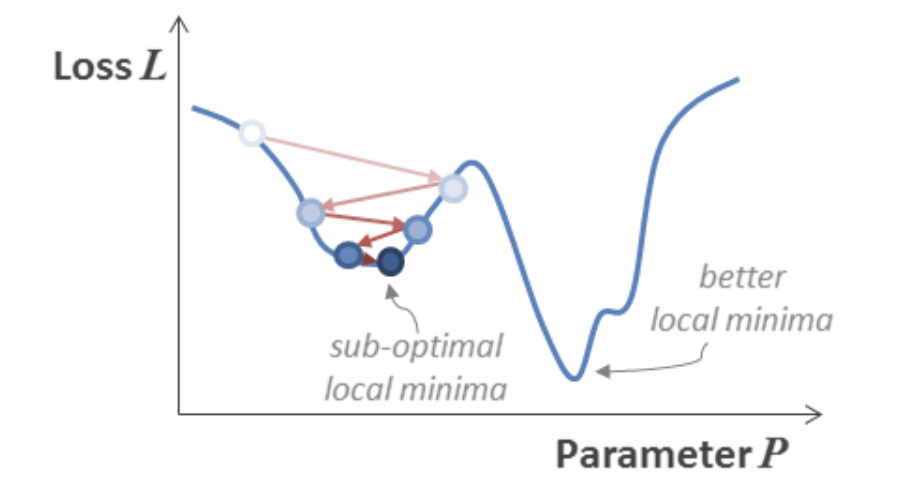

Also, the correct loss function in this context is BCE, so it is applied.

Keras decided to remove predifined metrics on a recent version, so metrics need to be manually defined.

In [86]:
# Building the model with the previous configurations

model.compile(
  optimizer= tf.keras.optimizers.experimental.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[f1_m,precision_m, recall_m])

In [87]:
# Starting CNN training and tracking completion time
st = time.time()
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_ds)

et = time.time()
elapsed_time = (et - st)/60
print('\nTraining took {}'.format(elapsed_time))

Epoch 1/10
11/11 [==============================] - 17s 989ms/step - loss: 236.3946 - f1_m: 0.3914 - precision_m: 0.3647 - recall_m: 0.4449 - val_loss: 0.6335 - val_f1_m: 0.3767 - val_precision_m: 0.3767 - val_recall_m: 0.3767
Epoch 2/10
11/11 [==============================] - 13s 1s/step - loss: 0.5999 - f1_m: 0.1667 - precision_m: 0.1667 - recall_m: 0.1667 - val_loss: 0.5795 - val_f1_m: 0.4967 - val_precision_m: 0.4967 - val_recall_m: 0.4967
Epoch 3/10
11/11 [==============================] - 11s 1s/step - loss: 0.5795 - f1_m: 0.2277 - precision_m: 0.2277 - recall_m: 0.2277 - val_loss: 0.5783 - val_f1_m: 0.4967 - val_precision_m: 0.4967 - val_recall_m: 0.4967
Epoch 4/10
11/11 [==============================] - 11s 1s/step - loss: 0.5746 - f1_m: 0.2228 - precision_m: 0.2228 - recall_m: 0.2228 - val_loss: 0.5789 - val_f1_m: 0.4967 - val_precision_m: 0.4967 - val_recall_m: 0.4967
Epoch 5/10
11/11 [==============================] - 12s 1s/step - loss: 0.5721 - f1_m: 0.1818 - precision_m

# Decision threshold
There is a function named perf_grid in the utils module that helps create the performance grid.
In the performance grid, thresholds increment from 0 to 1 by a step of 0.01 for each label.
For each threshold and for each label, we compute different measures (tp, fn, fp, precision, recall, f1-score).

In [88]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

In [89]:
# Get all label names
label_names = mlb.classes_
# Performance table with the first model 
grid = perf_grid(val_ds, y_val_bin, label_names, model)

3/3 [==============================] - 2s 488ms/step


The performance grid when using the binary crosstentropy-model looks like the following:



In [90]:
grid.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,0,0.5,0.00,170,0,173,0.495627,1.0,0.662768
1,0,0,0.5,0.01,170,0,173,0.495627,1.0,0.662768
2,0,0,0.5,0.02,170,0,173,0.495627,1.0,0.662768
3,0,0,0.5,0.03,170,0,173,0.495627,1.0,0.662768
4,0,0,0.5,0.04,170,0,173,0.495627,1.0,0.662768


For each label, there is a threshold that maximizes the performance of the model trained with the binary cross-entropy loss.
What labels have the highest maximum performance when using the bce loss?

In [91]:
# Get the maximum F1-score for each label when using the second model and varying the threshold

max_perf = grid.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max
0,0,0,0.500000,0.662768
1,2,2,0.380000,0.552743
2,1,1,0.120000,0.218182


Is there any correlation between the frequency of a label in the dataset and the performance achieved on it?

In [92]:
top5 = max_perf.head(3)['id']

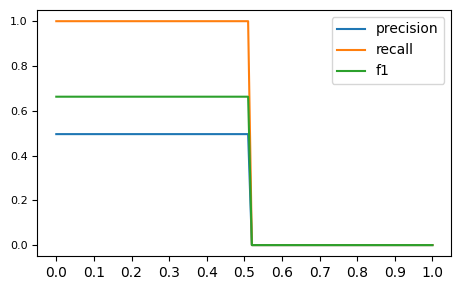

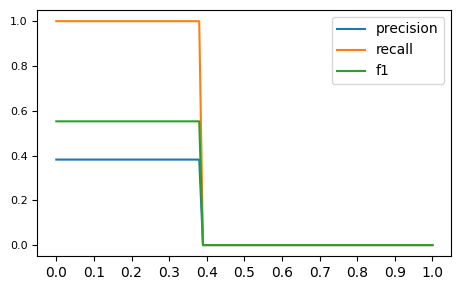

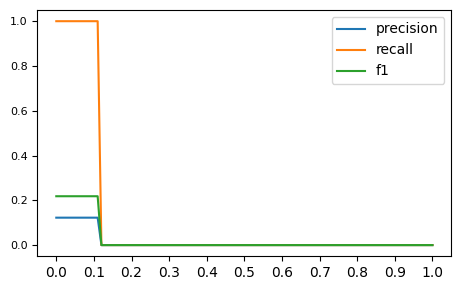

In [93]:
style.use("default")
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    label_grid.plot(ax=ax)
    
    
    plt.tight_layout()
    plt.show()